In [1]:
# imports
import pandas as pd
import os, ipdb, re
import random, evaluate
import string
import numpy as np
from collections import defaultdict
from tqdm import tqdm
from datasets import DatasetDict, Dataset, load_dataset
import wandb
import ast
import re, os
import subprocess

from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt

/nfs/home/kabenamualus/anaconda3/envs/tdm/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
def calculate_fuzz_ratio(text1, text2):
    return fuzz.ratio(str(text1).strip().lower(), str(text2).strip().lower())

def view_leaderboard_distribution(dfs):

    dfs_zeroshot = dfs['zeroshot'].copy()
    dfs_train = dfs['train'].copy()
    dfs_validation = dfs['validation'].copy()

    dfs_train['leaderboard'] = dfs_train.answer.apply(lambda x: "no_lb" if x == "unanswerable" else "lb")
    # Count unique values in the column
    counts_train = dfs_train['leaderboard'].value_counts()

    # Plot pie chart
    plt.figure(figsize=(8, 8))  # Optional: Adjusts the size of the figure
    plt.pie(counts_train, labels=counts_train.index, autopct='%1.1f%%', startangle=140)
    plt.title('Train Leaderboard vs No Leaderboard')
    plt.show()
    
    dfs_validation['leaderboard'] = dfs_validation.answer.apply(lambda x: "no_lb" if x == "unanswerable" else "lb")
    # Count unique values in the column
    counts_validation = dfs_validation['leaderboard'].value_counts()

    # Plot pie chart
    plt.figure(figsize=(8, 8))  # Optional: Adjusts the size of the figure
    plt.pie(counts_validation, labels=counts_validation.index, autopct='%1.1f%%', startangle=140)
    plt.title('Validation Chart Leaderboard vs No Leaderboard')
    plt.show()
    
    dfs_zeroshot['leaderboard'] = dfs_zeroshot.answer.apply(lambda x: "no_lb" if x == "unanswerable" else "lb")
    # Count unique values in the column
    counts = dfs_zeroshot['leaderboard'].value_counts()

    # Plot pie chart
    plt.figure(figsize=(8, 8))  # Optional: Adjusts the size of the figure
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
    plt.title('Zeroshot Chart Leaderboard vs No Leaderboard')
    plt.show()
    
    
def verify_data_integrity_old(dfs):

    zeroshot_paper_in_train = 0
    for paper in dfs['zeroshot'].id.unique():
        if paper in dfs['train'].id.to_list():
            zeroshot_paper_in_train += 1
        
    zeroshot_paper_in_validation = 0
    for paper in dfs['zeroshot'].id.unique():
        if paper in dfs['validation'].id.to_list():
            zeroshot_paper_in_validation += 1 

    train_paper_in_validation = 0
    for paper in dfs['train'].id.unique():
        if paper in dfs['validation'].id.to_list():
            train_paper_in_validation += 1   
        
    validation_paper_in_zeroshot = 0
    for paper in dfs['validation'].id.unique():
        if paper in dfs['zeroshot'].id.to_list():
            validation_paper_in_zeroshot += 1     
            
    print(f"zeroshot_paper_in_train: {zeroshot_paper_in_train}")
    print(f"zeroshot_paper_in_validation: {zeroshot_paper_in_validation}")
    print(f"train_paper_in_validation: {train_paper_in_validation}")
    print(f"validation_paper_in_zeroshot: {validation_paper_in_zeroshot}")
    
def verify_data_integrity(dfs, include_no_lb=True):

    zeroshot_paper_in_train = 0
    dfs_train = dfs['train'].copy()
    dfs_train.drop_duplicates(subset='id', inplace=True)
    dfs_validation = dfs['validation'].copy()
    dfs_validation.drop_duplicates(subset='id', inplace=True)
    dfs_zeroshot = dfs['zeroshot'].copy()
    dfs_zeroshot.drop_duplicates(subset='id', inplace=True)
    
    records_zero_train = dfs_zeroshot.to_dict("records")    
    for row in records_zero_train:
        if include_no_lb:
            if row['id'] in dfs_train['id'].to_list():
                zeroshot_paper_in_train += 1
        else:
            if row['id'] in dfs_train['id'].to_list() and row['leaderboard']!="no_lb":
                zeroshot_paper_in_train += 1
        
    zeroshot_paper_in_validation = 0
    records_zero_val = dfs_zeroshot.to_dict("records")
    for row in records_zero_val:
        if include_no_lb:
            if row['id'] in dfs_validation['id'].to_list():
                zeroshot_paper_in_validation += 1 
        else:
            if row['id'] in dfs_validation['id'].to_list() and row['leaderboard']!="no_lb":
                zeroshot_paper_in_validation += 1 

    validation_paper_in_train = 0
    records_val_train = dfs_validation.to_dict("records")
    for row in records_val_train:
        if include_no_lb:
            if row['id'] in dfs_train['id'].to_list():
                validation_paper_in_train += 1   
        else:
            if row['id'] in dfs_train['id'].to_list() and row['leaderboard']!="no_lb":
                validation_paper_in_train += 1   
        
    validation_paper_in_zeroshot = 0
    records_train_zero = dfs_validation.to_dict("records")
    for row in records_train_zero:
            
        if include_no_lb:
            if row['id'] in dfs_zeroshot['id'].to_list():
                validation_paper_in_zeroshot += 1     
        else:
            if row['id'] in dfs_zeroshot['id'].to_list() and row['leaderboard']!="no_lb":
                validation_paper_in_zeroshot += 1   
            
    print(f"zeroshot_paper_in_train: {zeroshot_paper_in_train}")
    print(f"zeroshot_paper_in_validation: {zeroshot_paper_in_validation}")
    print(f"validation_paper_in_train: {validation_paper_in_train}")
    print(f"validation_paper_in_zeroshot: {validation_paper_in_zeroshot}")
    
def remove_data_leakage_old(dfs, source, target, THRESHOLD=90):
    papers_to_drop = []
    missed_parsing_zero = 0
    
    dfs[source].drop_duplicates(subset='id', inplace=True)
    source_records = dfs[source].to_dict("records")

    for source_row in tqdm(source_records, total=len(source_records)):
        to_drop_paper_found = False 
        source_paper_id = source_row["id"]
        source_tdms = source_row["answer"]
        
        if source_tdms in "unanswerable" or source_tdms == "missed":
            # ipdb.set_trace()
            # if source_paper_id not in papers_to_drop:
            #     papers_to_drop.append(source_paper_id)
            continue 
        
        source_tdms = ast.literal_eval(source_row["answer"])
        
        for leaderboard_source in source_tdms:
            
            if to_drop_paper_found:
                break
            
            source_task = leaderboard_source["LEADERBOARD"]["Task"]
            source_dataset = leaderboard_source["LEADERBOARD"]["Dataset"]
            source_metric = leaderboard_source["LEADERBOARD"]["Metric"]
            source_score = leaderboard_source["LEADERBOARD"]["Score"]
 
            dfs[target].drop_duplicates(subset='id', inplace=True)
            
            target_records = dfs[target].to_dict("records")

            for target_row in target_records:
                
                if to_drop_paper_found:
                        break    
                
                target_paper_id = target_row["id"]
                target_tdms = target_row["answer"]
                
                if target_tdms == "unanswerable" or target_tdms == "missed":
                    # ipdb.set_trace()
                    continue 
                
                target_tdms = ast.literal_eval(target_row["answer"])
                
                
                for leaderboard_target in target_tdms:
                    target_task = leaderboard_target["LEADERBOARD"]["Task"]
                    target_dataset = leaderboard_target["LEADERBOARD"]["Dataset"]
                    target_metric = leaderboard_target["LEADERBOARD"]["Metric"]
                    target_score = leaderboard_target["LEADERBOARD"]["Score"]
                    
                    # A) Exact 
                    if (source_task == target_task and source_dataset == target_dataset and source_metric == target_metric) or (target_paper_id == source_paper_id):
                        if source_paper_id not in papers_to_drop:
                            papers_to_drop.append(source_paper_id)
                        to_drop_paper_found = True 
                        break
    
                    # # B) Partial  or # A) Exact 
                    # if (calculate_fuzz_ratio(train_task, zeroshot_task) >= THRESHOLD and calculate_fuzz_ratio(train_dataset, zeroshot_dataset) >= THRESHOLD and calculate_fuzz_ratio(train_metric, zeroshot_metric) >= THRESHOLD) or (train_task == zeroshot_task and train_dataset == zeroshot_dataset and train_metric == zeroshot_metric):
                    #     if paper_id not in papers_to_drop:
                    #         papers_to_drop.append(paper_id)
                    #         # ipdb.set_trace()
                    #         break 
                    
    print(f"Missed_parsing_zero {missed_parsing_zero}") 
    print(f"Lenght papers_to_drop in {source} based on {target}: {len(papers_to_drop)}")        
    
    return papers_to_drop


def remove_data_leakage_id(dfs, source, target, THRESHOLD=90):
    papers_to_drop = set()
    missed_parsing_zero = 0
    
    dfs[source].drop_duplicates(subset='id', inplace=True)
    records = dfs[source].to_dict("records")

    for row in tqdm(records, total=len(records)):
        to_drop_paper_found = False 
        source_paper_id = row["id"]
        
        dfs[target].drop_duplicates(subset='id', inplace=True)
        target_records = dfs[target].to_dict("records")

        for row_target in target_records:  
            
            target_paper_id = row_target["id"]
            
            # A) Exact 
            if (target_paper_id == source_paper_id):
                papers_to_drop.add(source_paper_id)
                to_drop_paper_found = True 
                break
                    
    print(f"Missed_parsing_zero {missed_parsing_zero}") 
    print(f"Lenght papers_to_drop in {source} based on {target}: {len(papers_to_drop)}")        
    
    return papers_to_drop


def remove_data_leakage(dfs, source, target, THRESHOLD=90):
    papers_to_drop = {"id": set(), "tdm":set()}
    missed_parsing_zero = 0
    
    dfs_target = dfs[target].drop_duplicates(subset='id')
    unique_paper_id_target = dfs_target.id.unique()
    lists_target = [ast.literal_eval(lb) for lb in dfs_target[dfs_target.leaderboard =="lb"].answer.to_list()]
    # Flatten the list of lists
    flattened_list_target = [item for sublist in lists_target for item in sublist]
    # Extract unique tuples
    unique_tuples_target = {(d['LEADERBOARD']['Task'], d['LEADERBOARD']['Dataset'], d['LEADERBOARD']['Metric']) for d in flattened_list_target}


    dfs_source = dfs[source].drop_duplicates(subset='id')
    source_records = dfs_source.to_dict("records")
    for source_row in tqdm(source_records, total=len(source_records)):
        to_drop_paper_found = False 
        source_paper_id = source_row["id"]
        source_tdms = source_row["answer"]
        
        if source_paper_id in unique_paper_id_target:
            papers_to_drop["id"].add(source_paper_id)
            continue     
        
        if source_tdms in "unanswerable" or source_tdms == "missed":
            # ipdb.set_trace()
            # if source_paper_id not in papers_to_drop:
            #     papers_to_drop.append(source_paper_id)
            continue 
        
        source_tdms = ast.literal_eval(source_row["answer"])
        # Extract unique tuples
        unique_tuples_source = {(d['LEADERBOARD']['Task'], d['LEADERBOARD']['Dataset'], d['LEADERBOARD']['Metric']) for d in source_tdms} 
        
        is_contained = unique_tuples_source.issubset(unique_tuples_target)
    
        if is_contained:
            papers_to_drop["tdm"].add(source_paper_id)
            
      
        
        # # B) Partial  or # A) Exact 
        # if (calculate_fuzz_ratio(train_task, zeroshot_task) >= THRESHOLD and calculate_fuzz_ratio(train_dataset, zeroshot_dataset) >= THRESHOLD and calculate_fuzz_ratio(train_metric, zeroshot_metric) >= THRESHOLD) or (train_task == zeroshot_task and train_dataset == zeroshot_dataset and train_metric == zeroshot_metric):
        #     if paper_id not in papers_to_drop:
        #         papers_to_drop.append(paper_id)
        #         # ipdb.set_trace()
        #         break 
                    
    print(f"Missed_parsing_zero {missed_parsing_zero}") 
    print(f"Lenght papers_to_drop in {source} based on {target} Title ID: {len(papers_to_drop['id'])}") 
    print(f"Lenght papers_to_drop in {source} based on {target} TDM Match: {len(papers_to_drop['tdm'])}")   

    print(f"Lenght papers from {source} with lb: {len(dfs_source[dfs_source['leaderboard']=='lb'])}") 
    print(f"Lenght papers from {source} with no_lb: {len(dfs_source[dfs_source['leaderboard']=='no_lb'])}") 
    print(f"Lenght papers from {target} with lb: {len(dfs_target[dfs_target['leaderboard']=='lb'])}") 
    print(f"Lenght papers from {target} with no_lb: {len(dfs_target[dfs_target['leaderboard']=='no_lb'])}") 
    
    
    return papers_to_drop

In [58]:
# dataset_path = "../data/LLLM_AUGMENTED_SUMMARIZED_WITH_ID_ZEROSHOT_TDMS_ALL_TEMPLATE/fold1"
# dataset_path = f"../data/LLLM_AUGMENTED_SUMMARIZED_WITH_ID_ZEROSHOT_TDMS_50_PERCENT/fold1"
# dataset_path = f"../data/LLLM_AUGMENTED_SUMMARIZED_ZEROSHOT_TDMS_50_PERCENT_LONG/fold1"
# dataset_path = f"../data/LLLM_AUGMENTED_SUMMARIZED_ZEROSHOT_TDMS_50_PERCENT_DOCTEAT/fold1"
# dataset_path = f"../data/LLLM_AUGMENTED_SUMMARIZED_ZEROSHOT_TDMS_NO_TEMPLATE_DOCTEAT/fold1"

#### CORRECTED #####

# dataset_path = f"../data/LEADERBOARDS_DOCTEAT_TDMS_ALL_TEMPLATES"
# dataset_path = f"../data/LEADERBOARDS_DOCTEAT_TDMS_NO_TEMPLATES_STRICT"
# dataset_path = f"../data/LEADERBOARDS_DOCTEAT_TDMS_NO_TEMPLATES_RELAX"
# dataset_path = f"../data/LEADERBOARDS_REC_TDMS_50_PERCENT_TEMPLATES"
# dataset_path = f"../data/LEADERBOARDS_DOCTEAT_TDMS_50_PERCENT_TEMPLATES"
dataset_path = f"../data/LEADERBOARDS_LONG_TDMS_50_PERCENT_TEMPLATES"

dataset_dict = DatasetDict.load_from_disk(f"{dataset_path}")
    

train_data = dataset_dict["train"].shuffle(seed=42)
valid_data = dataset_dict["validation"].shuffle(seed=42)
zeroshot_data = dataset_dict["zeroshot"].shuffle(seed=42)

# valid_data = dataset["validation"].shard(num_shards=10, index=0).shuffle(seed=42)

# train_data[0]˜
len(valid_data)

Loading cached shuffled indices for dataset at /nfs/home/kabenamualus/Research/LLLM-LeaderboardLLM/data/LEADERBOARDS_LONG_TDMS_50_PERCENT_TEMPLATES/train/cache-cfc3b7af4210e1e0.arrow
Loading cached shuffled indices for dataset at /nfs/home/kabenamualus/Research/LLLM-LeaderboardLLM/data/LEADERBOARDS_LONG_TDMS_50_PERCENT_TEMPLATES/validation/cache-225d4f14f9772491.arrow
Loading cached shuffled indices for dataset at /nfs/home/kabenamualus/Research/LLLM-LeaderboardLLM/data/LEADERBOARDS_LONG_TDMS_50_PERCENT_TEMPLATES/zeroshot/cache-92e0be151c1b0db8.arrow


10296

In [59]:
valid_data[random.randint(0, len(valid_data))]

# valid_data[1295]


{'id': '1604.02528.pdf',
 'prompt': 'Read this article and answer this question Title:\tA Left-Looking Selected Inversion Algorithm and Task Parallelism on Shared Memory Systems\n\nAbstract:\tGiven a sparse matrix A, the selected inversion algorithm is an efficient method for computing certain selected elements of A⁻¹. These selected elements correspond to all or some nonzero elements of the LU factors of A. In many ways, the type of matrix updates performed in the selected inversion algorithm is similar to that performed in the LU factorization, although the sequence of operation is different. In the context of LU factorization, it is known that the left-looking and right-looking algorithms exhibit different memory access and data communication patterns, and hence different behavior on shared memory and distributed memory parallel machines. Corresponding to right-looking and left-looking LU factorization, selected inversion algorithm can be organized as a left-looking and a right-look

In [60]:
dfs = {split: dataset.to_pandas() for split, dataset in dataset_dict.items()}

# dfs['validation'].head()

In [61]:
# dfs['zeroshot'].answer.unique()

In [62]:
train_ids = dfs['train']['id'].to_list()
valid_ids = dfs['validation']['id'].to_list()
zeroshot_ids = dfs['zeroshot']['id'].to_list()

print(f"len train_ids {len(train_ids)}")
print(f"len valid_ids {len(valid_ids)}")
print(f"len zeroshot_ids {len(zeroshot_ids)}")

train_ids =  set(dfs['train']['id'].to_list())
valid_ids = set(dfs['validation']['id'].to_list())
zeroshot_ids = set(dfs['zeroshot']['id'].to_list())

print(f"len train_ids {len(train_ids)}")
print(f"len valid_ids {len(valid_ids)}")
print(f"len zeroshot_ids {len(zeroshot_ids)}")

len train_ids 88535
len valid_ids 10296
len zeroshot_ids 5674
len train_ids 11807
len valid_ids 1326
len zeroshot_ids 746


In [63]:
count_i = []
for paper_id in zeroshot_ids:
    if paper_id in train_ids:
        count_i.append(paper_id)
        # print(f"In train: {paper_id}")
    # if paper in valid_ids:
    #     print(f"In valid {paper}")
    
print(f"Count_i: {len(count_i)}")

Count_i: 0


In [64]:
dfs['train'].head()

,id,prompt,answer,template,prompt lenght,leaderboard
0,2005.10469v1.pdf,Title:\tASAPP-ASR: Multistream CNN and Self-At...,[{'LEADERBOARD': {'Task': 'Speech Recognition'...,squad_1,3595,lb
1,1801.07606v1.pdf,Title:\tDeeper Insights into Graph Convolution...,[{'LEADERBOARD': {'Task': 'Node Classification...,squad_1,5620,lb
2,1706.03762v7.pdf,Title:\tAttention Is All You Need\n\nAbstract:...,[{'LEADERBOARD': {'Task': 'Machine Translation...,squad_1,5466,lb
3,2301.13808v3.pdf,Title:\tLarge Language Models are Versatile De...,"[{'LEADERBOARD': {'Task': 'Semantic Parsing', ...",squad_1,5182,lb
4,2007.12749v2.pdf,"Title:\tHard negative examples are hard, but u...","[{'LEADERBOARD': {'Task': 'Metric Learning', '...",squad_1,5348,lb


In [65]:
# dfs['train'].drop("prompt lenght", axis=1).describe()
# dfs['train'].drop(["__index_level_0__", "prompt lenght"], axis=1).describe()

dfs['train'].describe()

,prompt lenght
count,88535.000000
mean,5948.924798
std,3950.935787
min,26.000000
25%,3924.000000
50%,5277.000000
75%,7064.000000
max,127689.000000


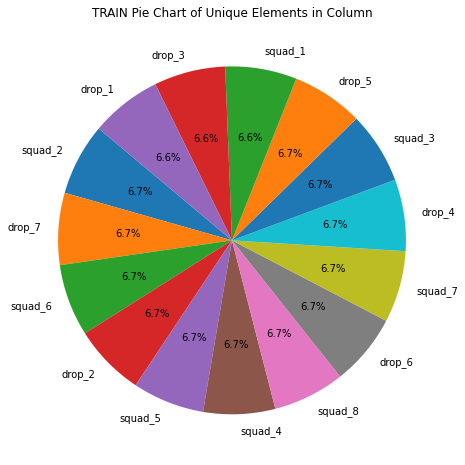

In [66]:
# dfs['validation'].template.

# Count unique values in the column
counts = dfs['train'].template.value_counts()

# Plot pie chart
plt.figure(figsize=(8, 8))  # Optional: Adjusts the size of the figure
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
plt.title('TRAIN Pie Chart of Unique Elements in Column')
plt.show()

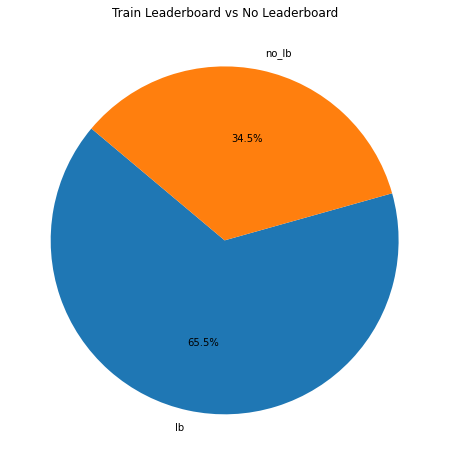

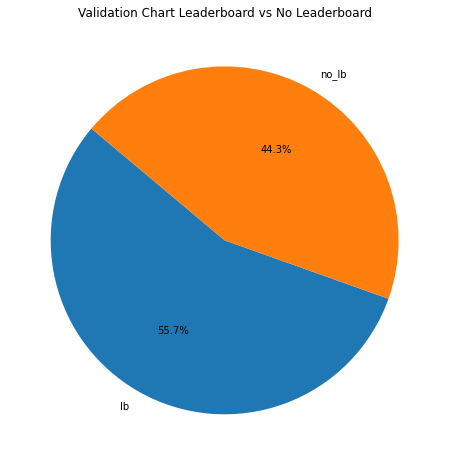

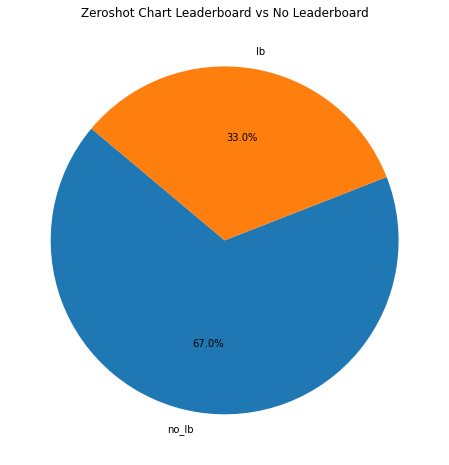

In [67]:
view_leaderboard_distribution(dfs)

In [68]:
# dfs['validation'].drop(["prompt lenght", "__index_level_0__"], axis=1).describe()
dfs['validation'].drop(["__index_level_0__"], axis=1).describe()

# dfs['validation'].describe()

,prompt lenght
count,10296.000000
mean,6011.195901
std,3465.069448
min,41.000000
25%,4267.000000
50%,5331.000000
75%,6886.000000
max,33574.000000


In [69]:
dfs['train']["id"].nunique()

11807

In [70]:
dfs['train']["template"].unique()

array(['squad_1', 'squad_2', 'squad_3', 'squad_4', 'squad_5', 'squad_6',
       'squad_7', 'squad_8', 'drop_1', 'drop_2', 'drop_3', 'drop_7',
       'drop_4', 'drop_5', 'drop_6'], dtype=object)

In [71]:
# 12388*15
12388*14
# 92910*2

173432

In [72]:
dfs['train']["prompt lenght"] = dfs['train']["prompt"].apply(lambda x: len(x.split()))
dfs['train']["answer lenght"] = dfs['train']["answer"].apply(lambda x: len(x.split()))

dfs['validation']["prompt lenght"] = dfs['validation']["prompt"].apply(lambda x: len(x.split()))
dfs['validation']["answer lenght"] = dfs['validation']["answer"].apply(lambda x: len(x.split()))
    
dfs['zeroshot']["prompt lenght"] = dfs['zeroshot']["prompt"].apply(lambda x: len(x.split()))
dfs['zeroshot']["answer lenght"] = dfs['zeroshot']["answer"].apply(lambda x: len(x.split()))

In [73]:
# dfs['train'].drop(["prompt lenght", "__index_level_0__"], axis=1).describe()
dfs['train'].describe()

,prompt lenght,answer lenght
count,88535.000000,88535.000000
mean,5948.924798,55.366691
std,3950.935787,131.559734
min,26.000000,1.000000
25%,3924.000000,1.000000
50%,5277.000000,21.000000
75%,7064.000000,60.000000
max,127689.000000,5866.000000


In [74]:
dfs['validation'].describe()

,prompt lenght,__index_level_0__,answer lenght
count,10296.000000,10296.000000,10296.000000
mean,6011.195901,6078.419775,40.175408
std,3465.069448,3512.540291,73.846617
min,41.000000,0.000000,1.000000
25%,4267.000000,3036.500000,1.000000
50%,5331.000000,6085.000000,11.000000
75%,6886.000000,9130.250000,48.000000
max,33574.000000,12095.000000,699.000000


# Stats

In [75]:
import numpy as np

def describe_list(lst):
    # Count
    count = len(lst)
    
    # Mean
    mean = np.mean(lst)
    
    # Standard deviation
    std = np.std(lst)
    
    # Minimum
    min_val = np.min(lst)
    
    # 25th Percentile
    percentile_25 = np.percentile(lst, 25)
    
    # Median
    median = np.median(lst)
    
    # 75th Percentile
    percentile_75 = np.percentile(lst, 75)
    
    # Maximum
    max_val = np.max(lst)
    
    result = {
        'count': count,
        'mean': mean,
        'std': std,
        'min': min_val,
        '25%': percentile_25,
        '50%': median,
        '75%': percentile_75,
        'max': max_val
    }
    
    return result


def get_df_stats_v1(df): 
    
    unique_labels = df.answer.tolist()
    
    TDMS = set()
    Uniq_task = set()
    Uniq_dataset = set()
    Uniq_metric = set()
    Uniq_score = set()
    unanswerable_count = 0
    tdms_per_paper = []
    
    for contrib in unique_labels:
        try:
            parsed_json = ast.literal_eval(contrib)
        except :
            # TODO: We need a best way to deal with this 

            if contrib == 'unanswerable':
                unanswerable_count += 1
                continue
            else:
                ipdb.set_trace()
                print(f"Error parsing: \n{contrib}")
                # missed += 1
                parsed_json =  contrib
        tdms_count = 0
        for leaderboard in parsed_json:

            task = leaderboard['LEADERBOARD']['Task'].strip()
            dataset = leaderboard['LEADERBOARD']['Dataset'].strip()
            metric = leaderboard['LEADERBOARD']['Metric'].strip()
            score = leaderboard['LEADERBOARD']['Score'].strip()

            TDMS.add(f"{task}#{dataset}#{metric}#{score}")
            
            Uniq_task.add(task)
            Uniq_dataset.add(dataset)
            Uniq_metric.add(metric)
            Uniq_score.add(score)
            tdms_count += 1
            # ipdb.set_trace()
        
        tdms_per_paper.append(tdms_count)
        
        
    print(f"Number of papers: {len(df.id.tolist())}")
    print(f"Unanswerable count: {unanswerable_count}")
    # print(f"Total leaderboards: {len(path_to_df[(path_to_df.label == True) & (path_to_df.TDM != 'unknown')].title.tolist())}")
    print(f"Avg leaderboard per paper: {round(np.mean(list(tdms_per_paper)), 2)}")
    print(f"Distinc leaderboard: {len(TDMS)}")
    print(f"Distinct taks: {len(Uniq_task)}")
    print(f"Distinc datasets: {len(Uniq_dataset)}")
    print(f"Distinc metrics: {len(Uniq_metric)}")
    print(f"Distinc score: {len(Uniq_score)}")
    print(f"Max leaderboard per paper: {round(np.max(list(tdms_per_paper)), 2)}")
    print(f"Min leaderboard per paper: {round(np.min(list(tdms_per_paper)), 2)}")

    describe_result = describe_list(tdms_per_paper)

    print(f"\nResults describe TDMS:")
    for key, value in describe_result.items():
        print(f"{key}: {value}")
    
    return tdms_per_paper

def get_df_stats(df):     
    Global_TDM = []
    Global_TDMS = []
    Uniq_task = set()
    Uniq_dataset = set()
    Uniq_metric = set()
    Uniq_score = set()
    unanswerable_count = 0
    answerable_count = 0
    tdms_count = 0
    tdms_per_paper = []
    tdm_per_paper = []
    seen_paper_lb = set()
    seen_paper_no_lb = set()
    
    records = df.to_dict("records")
    missed_parsing = []
  
    for i, row in tqdm(enumerate(records), total = len(records)):
        if row['answer'] == 'unanswerable':
            if row['id'] not in seen_paper_no_lb:
                unanswerable_count += 1
            seen_paper_no_lb.add(row['id'])
            continue
        else:
                    
            try:
                parsed_json = ast.literal_eval(row['answer'])
            except :
                # TODO: We need a best way to deal with this 
                ipdb.set_trace() 
                print(f"Error parsing: \n{row['answer']}")
                missed_parsing += 1
                parsed_json =  row['answer']
                continue
                
            
        TDMS = set()
        TDM = set()
        
        for leaderboard in parsed_json:

            task = leaderboard['LEADERBOARD']['Task'].strip()
            dataset = leaderboard['LEADERBOARD']['Dataset'].strip()
            metric = leaderboard['LEADERBOARD']['Metric'].strip()
            score = leaderboard['LEADERBOARD']['Score'].strip()

            TDM.add(f"{task}#{dataset}#{metric}")
            TDMS.add(f"{task}#{dataset}#{metric}#{score}")
            
            Global_TDM.append(f"{task}#{dataset}#{metric}")
            Global_TDMS.append(f"{task}#{dataset}#{metric}#{score}")
            
            Uniq_task.add(task)
            Uniq_dataset.add(dataset)
            Uniq_metric.add(metric)
            Uniq_score.add(score)
            tdms_count += 1
        
        tdm_per_paper.append(len(TDM))
        tdms_per_paper.append(len(TDMS))
                
        seen_paper_lb.add(row['id'])        
        
    print(f"Papers w/ leaderboards: {len(seen_paper_lb)}")
    print(f"Papers w/o leaderboards: {len(seen_paper_no_lb)} ~ {unanswerable_count}")
    # print(f"Total TDM-triples : {tdms_count+1}") 
    print(f"Total TDM-triples : {len(Global_TDM)+1}") 
    print(f"Distinct TDM-triples: {len(set(Global_TDM))+1}") # +1 for unanswerable
    print(f"Distinct taks: {len(Uniq_task)}")
    print(f"Distinc datasets: {len(Uniq_dataset)}")
    print(f"Distinc metrics: {len(Uniq_metric)}")
    print(f"Avg. no. of TDM per paper : {round(np.mean(tdm_per_paper), 2)}")
    print(f"Avg. no. of TDMS per paper : {round(np.mean(tdms_per_paper), 2)}")
    
    print(f"Distinc score: {len(Uniq_score)}")
    print(f"Max leaderboard per paper: {round(np.max(tdms_per_paper), 2)}")
    print(f"Min leaderboard per paper: {round(np.min(tdms_per_paper), 2)}")
    
    # print(f"Total leaderboards: {len(path_to_df[(path_to_df.label == True) & (path_to_df.TDM != 'unknown')].title.tolist())}")
    print(f"Total missed parsing: {len(missed_parsing)}")
    print(f"Distinct TDMs-triples: {len(TDMS)}")

    describe_result = describe_list(tdms_per_paper)

    print(f"\nResults describe TDMS:")
    for key, value in describe_result.items():
        print(f"{key}: {value}")
    
    return tdms_per_paper

In [76]:
dfs['validation'].head()

,id,prompt,answer,template,prompt lenght,leaderboard,__index_level_0__,answer lenght
0,1712.02047v1.pdf,Title:\tDistance-based Self-Attention Network ...,[{'LEADERBOARD': {'Task': 'Natural Language In...,squad_1,4779,lb,0,37
1,1508.01819v1.pdf,Title:\tSpectral Clustering and Block Models: ...,unanswerable,squad_1,8735,no_lb,1,1
2,1909.04810v3.pdf,Title:\t Antipodal Robotic Grasping using\nGen...,unanswerable,squad_1,5096,no_lb,2,1
3,1310.7697.pdf,Title:\tLinear Convergence of Comparison-based...,unanswerable,squad_1,15785,no_lb,3,1
4,1601.02071.pdf,Title:\tSentiment Visualisation Widgets for Ex...,unanswerable,squad_1,4632,no_lb,4,1


In [77]:
tdms_per_paper_train = get_df_stats(dfs['train'])

100%|██████████| 88535/88535 [00:04<00:00, 18470.22it/s]


Papers w/ leaderboards: 7744
Papers w/o leaderboards: 4063 ~ 4063
Total TDM-triples : 402409
Distinct TDM-triples: 11814
Distinct taks: 1365
Distinc datasets: 4733
Distinc metrics: 2845
Avg. no. of TDM per paper : 5.13
Avg. no. of TDMS per paper : 6.94
Distinc score: 18151
Max leaderboard per paper: 356
Min leaderboard per paper: 1
Total missed parsing: 0
Distinct TDMs-triples: 2

Results describe TDMS:
count: 57966
mean: 6.942138494979816
std: 11.853385247388296
min: 1
25%: 2.0
50%: 4.0
75%: 8.0
max: 356


In [78]:
tdms_per_paper_validation = get_df_stats(dfs['validation'])

 29%|██▉       | 2977/10296 [00:00<00:00, 29764.92it/s]

100%|██████████| 10296/10296 [00:00<00:00, 28532.08it/s]

Papers w/ leaderboards: 722
Papers w/o leaderboards: 604 ~ 604
Total TDM-triples : 33863
Distinct TDM-triples: 1875
Distinct taks: 308
Distinc datasets: 921
Distinc metrics: 643
Avg. no. of TDM per paper : 4.87
Avg. no. of TDMS per paper : 5.91
Distinc score: 2786
Max leaderboard per paper: 59
Min leaderboard per paper: 1
Total missed parsing: 0
Distinct TDMs-triples: 11

Results describe TDMS:
count: 5731
mean: 5.908567440237306
std: 7.080538370434505
min: 1
25%: 2.0
50%: 4.0
75%: 7.0
max: 59


In [80]:
tdms_per_paper_validation = get_df_stats(dfs['zeroshot'])

100%|██████████| 5674/5674 [00:00<00:00, 18287.43it/s]

Papers w/ leaderboards: 239
Papers w/o leaderboards: 507 ~ 507
Total TDM-triples : 14604
Distinct TDM-triples: 1246
Distinct taks: 236
Distinc datasets: 642
Distinc metrics: 398
Avg. no. of TDM per paper : 6.05
Avg. no. of TDMS per paper : 7.81
Distinc score: 1442
Max leaderboard per paper: 170
Min leaderboard per paper: 1
Total missed parsing: 0
Distinct TDMs-triples: 1

Results describe TDMS:
count: 1870
mean: 7.8090909090909095
std: 14.013951136145758
min: 1
25%: 2.0
50%: 4.0
75%: 9.0
max: 170
